In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, Dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from PIL import Image

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.preprocessing.bio_technique.make_dataset import *
from src.model.bio_technique.trainer import BioTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "BioTechnique"
dataset_name = "FUNSD"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Loading FUNSD Dataset

In [4]:
funsd_dataset = load_dataset("nielsr/funsd")

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
n_classes = len(funsd_dataset['train'].features['ner_tags'].feature.names)
n_classes

7

In [7]:
l = funsd_dataset['train'].features['ner_tags'].feature.names

In [8]:
idx2label = {}
for k, v in enumerate(l):
    if v == 'O':
        idx2label[k] = "none"

    else:
        idx2label[k] = v.split('-')[1].lower() 

In [29]:
label_names =["header", "question", "answer", "none"]

In [30]:
tokenizer.sep_token

'[SEP]'

## Running model without line split

### 2 Shots

In [58]:
train_data = generate_dataset(
    funsd_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=2,
)

val_data = generate_dataset(
    funsd_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    Dataset.from_dict(funsd_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [59]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

100%|██████████| 8/8 [00:00<00:00, 241.19it/s]


In [60]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 291.80it/s]


In [61]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= 4
)

  5%|▌         | 29/556 [00:00<00:01, 283.38it/s]

100%|██████████| 556/556 [00:01<00:00, 330.54it/s]


In [70]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer
)

history = trainer.compile(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 100
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [06:17<00:00,  3.77s/it]


In [85]:
best_f1, best_epoch = np.max(history), np.argmax(history)

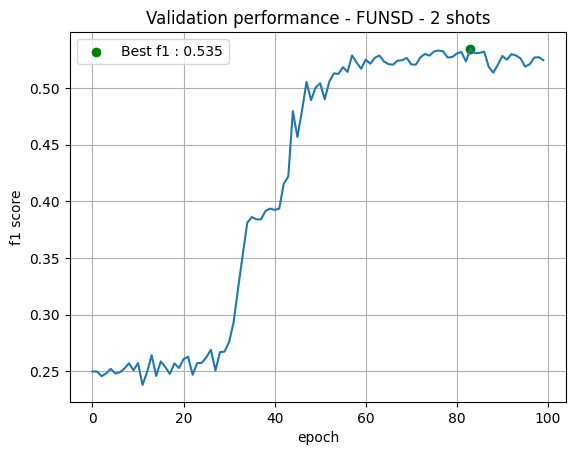

In [72]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title("Validation performance - FUNSD - 2 shots")
plt.grid()

In [73]:
y_pred_val = torch.tensor([],device=device)
y_true_val = torch.tensor([],device=device)
for batch in tqdm(test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)

        if k == "bbox":
            continue
        batch[k] = batch[k].reshape(4,512)
    batch.pop('bbox')

    y_true = batch['labels']
    mask = y_true!= -100

    with torch.no_grad():
        y_pred = model(**batch).logits[:,:,1]
    y_pred = y_pred[mask]\
        .reshape(4,-1)[:,1:]\
        .argmax(dim = 0)

    y_true = y_true[mask]\
        .reshape(4,-1)[:, 1:]\
        .argmax(dim = 0)
    
    y_pred_val = torch.cat([y_pred, y_pred_val])
    y_true_val = torch.cat([y_true, y_true_val])

f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=4
)

conf_matrix = multiclass_confusion_matrix(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes= 4
)

if f1 > best_f1:
    best_f1 = f1
    best_model = deepcopy(model)

logging.info(f"f1 score: {f1}")
logging.info(conf_matrix)

  0%|          | 0/139 [00:00<?, ?it/s]

100%|██████████| 139/139 [00:08<00:00, 16.04it/s]


In [74]:
label_names

['header', 'question', 'answer', 'none']

Text(0.5, 1.0, 'Performance - FUNSD - 2 shots')

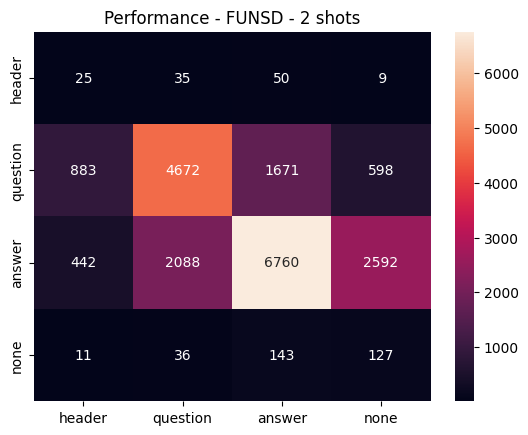

In [75]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 2 shots")


### 5 Shots

In [76]:
train_data = generate_dataset(
    funsd_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=5,
)

val_data = generate_dataset(
    funsd_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    Dataset.from_dict(funsd_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [77]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 278.01it/s]


In [78]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 292.70it/s]


In [79]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/556 [00:00<?, ?it/s]

100%|██████████| 556/556 [00:01<00:00, 344.04it/s]


In [84]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer
)

history = trainer.compile(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 100
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [07:38<00:00,  4.59s/it]


In [86]:
best_f1, best_epoch = np.max(history), np.argmax(history)

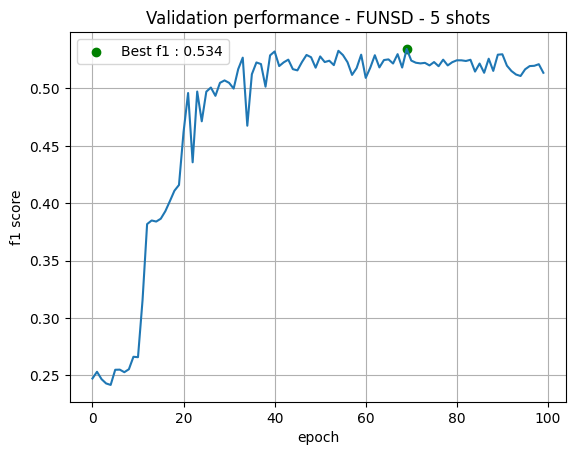

In [87]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title("Validation performance - FUNSD - 5 shots")
plt.grid()

In [88]:
y_pred_val = torch.tensor([],device=device)
y_true_val = torch.tensor([],device=device)
for batch in tqdm(test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)

        if k == "bbox":
            continue
        batch[k] = batch[k].reshape(4,512)
    batch.pop('bbox')

    y_true = batch['labels']
    mask = y_true!= -100

    with torch.no_grad():
        y_pred = model(**batch).logits[:,:,1]
    y_pred = y_pred[mask]\
        .reshape(4,-1)[:,1:]\
        .argmax(dim = 0)

    y_true = y_true[mask]\
        .reshape(4,-1)[:, 1:]\
        .argmax(dim = 0)
    
    y_pred_val = torch.cat([y_pred, y_pred_val])
    y_true_val = torch.cat([y_true, y_true_val])

f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=4
)

conf_matrix = multiclass_confusion_matrix(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes= 4
)

if f1 > best_f1:
    best_f1 = f1
    best_model = deepcopy(model)

logging.info(f"f1 score: {f1}")
logging.info(conf_matrix)

  1%|▏         | 2/139 [00:00<00:08, 16.06it/s]

100%|██████████| 139/139 [00:08<00:00, 15.53it/s]


In [89]:
label_names

['header', 'question', 'answer', 'none']

Text(0.5, 1.0, 'Performance - FUNSD - 5 shots')

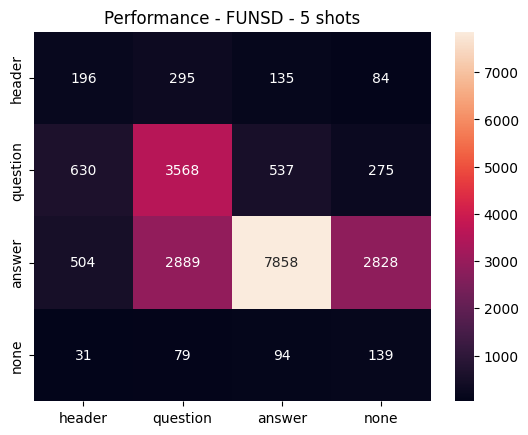

In [90]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 5 shots")


### 10 shots

In [42]:
train_data = generate_dataset(
    funsd_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=10,
)

val_data = generate_dataset(
    funsd_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    Dataset.from_dict(funsd_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [43]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 275.91it/s]


In [44]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 287.06it/s]


In [45]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/556 [00:00<?, ?it/s]

100%|██████████| 556/556 [00:01<00:00, 343.78it/s]


In [46]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer
)

history = trainer.compile(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 50
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 40/40 [00:02<00:00, 15.02it/s]


In [52]:
best_f1, best_epoch = np.max(history), np.argmax(history)

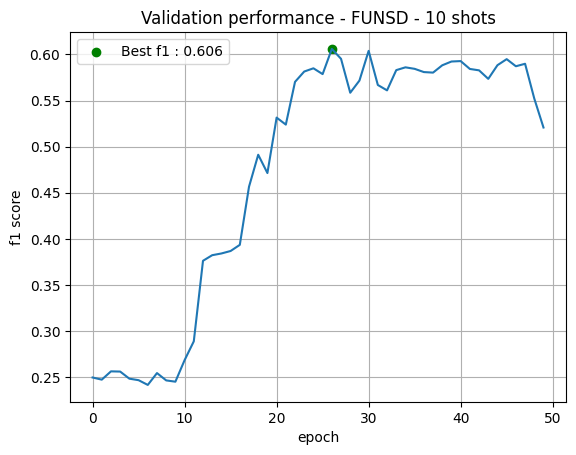

In [53]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title("Validation performance - FUNSD - 10 shots")
plt.grid()

In [54]:
y_pred_val = torch.tensor([],device=device)
y_true_val = torch.tensor([],device=device)
for batch in tqdm(test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)

        if k == "bbox":
            continue
        batch[k] = batch[k].reshape(4,512)
    batch.pop('bbox')

    y_true = batch['labels']
    mask = y_true!= -100

    with torch.no_grad():
        y_pred = model(**batch).logits[:,:,1]
    y_pred = y_pred[mask]\
        .reshape(4,-1)[:,1:]\
        .argmax(dim = 0)

    y_true = y_true[mask]\
        .reshape(4,-1)[:, 1:]\
        .argmax(dim = 0)
    
    y_pred_val = torch.cat([y_pred, y_pred_val])
    y_true_val = torch.cat([y_true, y_true_val])

f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=4
)

conf_matrix = multiclass_confusion_matrix(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes= 4
)

if f1 > best_f1:
    best_f1 = f1
    best_model = deepcopy(model)

logging.info(f"f1 score: {f1}")
logging.info(conf_matrix)

  0%|          | 0/139 [00:00<?, ?it/s]

100%|██████████| 139/139 [00:08<00:00, 15.81it/s]


In [55]:
label_names

['header', 'question', 'answer', 'none']

Text(0.5, 1.0, 'Performance - FUNSD - 10 shots')

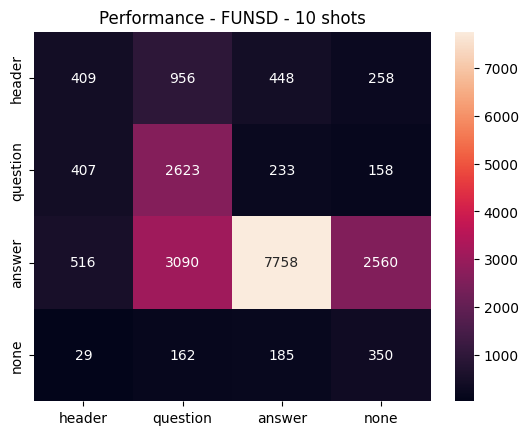

In [56]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 10 shots")


In [68]:
unnormalized_bbox_train = get_unnormalized_bboxes(funsd_dataset['train'])
unnormalized_bbox_val = get_unnormalized_bboxes(funsd_dataset['test'])

In [75]:
line_splitted_train_data = generate_text_from_same_line(
    funsd_dataset['train'],
    unnormalized_bbox_train,
    n_shots=5
)

In [77]:
line_splitted_val_data = generate_text_from_same_line(
    funsd_dataset['test'],
    unnormalized_bbox_val,
    n_shots = 50
)

In [78]:
train_data = generate_dataset(
    line_splitted_train_data,
    n_shots=10_000
)

val_data = generate_dataset(
    line_splitted_val_data,
    n_shots=50_000
)

In [79]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True
)

  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [00:00<00:00, 517.42it/s]


In [80]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/2192 [00:00<?, ?it/s]

100%|██████████| 2192/2192 [00:03<00:00, 590.68it/s] 


In [81]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

model.train()
best_f1 = 0
best_model = None

n_epochs = 50
history = []
for epoch in range(n_epochs):
    for batch in tqdm(train_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)

            if k == "bbox":
                continue
            batch[k] = batch[k].reshape(1,512)
        batch.pop('bbox')

        optimizer.zero_grad()

        out = model(**batch)
        loss = out.loss

        loss.backward()
        optimizer.step()

    y_pred_val = torch.tensor([],device=device)
    y_true_val = torch.tensor([],device=device)

    for batch in tqdm(validation_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)

            if k == "bbox":
                continue
            batch[k] = batch[k].reshape(4,512)
        batch.pop('bbox')

        y_true = batch['labels']
        mask = y_true!= -100

        with torch.no_grad():

            y_pred = model(**batch).logits[:,:,1]
        y_pred = y_pred[mask]\
            .reshape(4,-1)[:,1:]\
            .argmax(dim = 0)

        y_true = y_true[mask]\
            .reshape(4,-1)[:, 1:]\
            .argmax(dim = 0)
        
        y_pred_val = torch.cat([y_pred, y_pred_val])
        y_true_val = torch.cat([y_true, y_true_val])

    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=4
    )

    conf_matrix = multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes= 4
    )

    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    logging.info(f"f1 score: {f1}")
    logging.info(conf_matrix)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 55%|█████▌    | 212/384 [00:14<00:11, 14.82it/s]


KeyboardInterrupt: 